In [13]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook 
#exibe opções de manipulação
%matplotlib inline
#se usar pyplot
from IPython.display import Markdown as md

In [3]:
file = 'control_img_2.jpg'
#file = 'fig_true_19.jpg'
#file = 'pre_control1.jpg'
#file = 'fig_control_5.jpg'

bgr = cv.imread(file, cv.IMREAD_UNCHANGED) #also por fig_control_1.jpg 
#bgr = cv.resize(bgr, (780, 1040)) #restrict area cols, lin
print('Dim:' + str(bgr.shape))
#cv.imshow('bgr original img', bgr)
#cv.waitKey(0)  
#cv.destroyAllWindows() 


Dim:(960, 1600, 3)


<img src='control_img_2.jpg'></img>

In [9]:
#equalizar HSV
hsv = cv.cvtColor(bgr, cv.COLOR_BGR2HSV)
hsv_eq = 'eq_s'
hsv[:,:,1] = cv.equalizeHist(hsv[:,:,1])  #equalization S channel
bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR) #back conversion to BGR
file_equalized = file + '_equalized.jpg'
cv.imwrite(file_equalized, bgr)
#cv.waitKey(0)  
#cv.destroyAllWindows() 

True

In [21]:
char = "'"
file_to_show = ''.join( x for x in file_equalized if x not in char)
md("![eq](control_img_2.jpg_equalized.jpg 'Imagem Equalizada')")

![eq](control_img_2.jpg_equalized.jpg 'Imagem Equalizada')

### Imagem fig_true_19 sem foco na parte superior, remover e definir ROI

In [22]:
if file == 'fig_true_19.jpg':
    # Cropping an image
    bgr = bgr[43:bgr.shape[0],:,:]
    print(bgr.shape)

In [23]:
def filtroRGB(src,r,g,b):
    imret = src.copy() #na matriz é BGR
    if r == 0:
        imret[:,:,2] = 0    #elimina o vermelho
    if g == 0:
        imret[:,:,1] = 0    #elimina o verde
    if b == 0:
        imret[:,:,0] = 0    #elimina o azul
    return imret

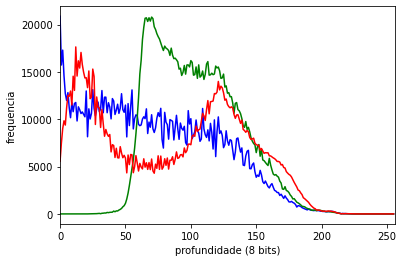

In [24]:
bgr_split_channels = cv.split(bgr)

# numero de bins do histograma
hist_size = 256
# faixa de valores de cada canal
hist_range = (0, 256) #0-255 (8 bits)
accumulate = False

histr = []
color = ('b','g','r') #h, s, v
for i,col in enumerate(color):
    histr.append(cv.calcHist(bgr_split_channels,[i],None, [hist_size], hist_range, accumulate=accumulate))
    plt.plot(histr[i], color = col)
    plt.xlim([0,256])
plt.xlabel('profundidade (8 bits)')
plt.ylabel('frequencia')
plt.show()

In [25]:
#desaturation - convert bgr to gray for limiarization
gray = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)

In [26]:
#auto otsu
#can be applied to uni e bimodal histograms
# segmentation based on shape, pixels (color), histogram
# binary segmentation - binarization, thresholding - only B channel
ret,th = cv.threshold(gray, 0, 255,cv.THRESH_BINARY+cv.THRESH_OTSU)

In [29]:
#contours, hierarchy = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
#contours, hierarchy = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
contours, hierarchy = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
#contours, hierarchy = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
#contours, hierarchy = cv.findContours(th, cv.RETR_CCOMP, cv.CHAIN_APPROX_NONE)
#contours, hierarchy = cv.findContours(th, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
print ('Foram encontrados ' + str(len(contours)) + ' objetos com seus contornos')

cv.drawContours(bgr, contours, -1, (0,242,255), 2)
cv.imshow('contours', bgr)
cv.waitKey(0)
cv.destroyAllWindows()

#print(hierarchy) - estudar hierarquia dos contornos
#print(contours[0])

Foram encontrados 601 objetos com seus contornos


In [38]:
def extract_image(im, cnt):
  # np.zeros: Cria uma matriz com determinadas dimensões
  im_blank = np.zeros(im.shape, np.uint8) #imagem toda em preto
  cv.drawContours(im_blank, [cnt], -1, 255, 2) #desenha contorno branco sobre o fundo preto vazio
  mask = im_blank == 255 # a máscara são os pontos brancos do contorno
  im_filter = im[mask]
  return im_filter

In [39]:
#https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html
areas = []
perimeters = []
centroids_x = []
centroids_y = []
aspect_ratio = [] #It is the ratio of width to height of bounding rect of the object.
extent = [] #Extent is the ratio of contour area to bounding rectangle area.
solidity = [] #Solidity is the ratio of contour area to its convex hull area.
equivalent_diameter = [] #Equivalent Diameter is the diameter of the circle whose area is same as the contour area.
r_mean = []
r_min = []
r_max = []
r_std = []
g_mean = []
g_min = []
g_max = []
g_std = []
b_mean = []
b_min = []
b_max = []
b_std = []
width = []
height = []
angle = []
radius = []

for c in contours:
    M = cv.moments(c)
    
    areas.append(M['m00'])
    perimeters.append(cv.arcLength(c,True)) #if not convex, False
    
    x,y,w,h = cv.boundingRect(c)
    aspect_ratio.append(float(w)/h)
    width.append(w)
    height.append(h)
    rect = cv.minAreaRect(c)
    circle = cv.minEnclosingCircle(c)
    angle.append(rect[2])
    radius.append(circle[1])
    
    rect_area = w*h
    if rect_area > 0:
        extent.append(M['m00']/rect_area)
    else: 
        extent.append(0)
    
    hull = cv.convexHull(c)
    hull_area = cv.contourArea(hull)
    if hull_area > 0:
        solidity.append(M['m00']/hull_area)
    else:
        solidity.append(0)
    
    equivalent_diameter = np.sqrt(4*M['m00']/np.pi)
    
    if M['m00'] != 0:
        centroids_x.append(M['m10']/M['m00'])
        centroids_y.append(M['m01']/M['m00'])
    else:
        centroids_x.append(0)
        centroids_y.append(0)
        
    r = extract_image(bgr_split_channels[2], c)
    g = extract_image(bgr_split_channels[1], c)
    b = extract_image(bgr_split_channels[0], c)
    
    r_mean.append(np.mean(r))
    r_max.append(np.max(r))
    r_min.append(np.min(r))
    r_std.append(np.std(r))
    g_mean.append(np.mean(g))
    g_max.append(np.max(g))
    g_min.append(np.min(g))
    g_std.append(np.std(g))
    b_mean.append(np.mean(b))
    b_max.append(np.max(b))
    b_min.append(np.min(b))
    b_std.append(np.std(b))
    
        


In [40]:
import pandas as pd
# TUDO (GEOMETRIA e COR)
features_1 = {'area': areas, 'perimiter': perimeters, 'aspect_ratio': aspect_ratio, 
            'extent': extent, 'solidity': solidity, 'equivalent_diameter': equivalent_diameter,
            'r_mean': r_mean, 'r_max': r_max, 'r_min': r_min, 'r_std': r_std,
            'g_mean': g_mean, 'g_max': g_max, 'g_min': g_min, 'g_std': g_std,
            'b_mean': b_mean, 'b_max': b_max, 'b_min': b_min, 'b_std': b_std,
            'width': width, 'height': height, 'angle': angle, 'radius': radius
}

# SÓ GEOMETRIA
features_2 = {'area': areas, 'perimiter': perimeters, 'aspect_ratio': aspect_ratio, 
            'extent': extent, 'solidity': solidity, 'equivalent_diameter': equivalent_diameter,
              'width': width, 'height': height, 'angle': angle, 'radius': radius
}

#apenas as estatísticas dos canais RGB
features_3 = {'r_mean': r_mean, 'r_max': r_max, 'r_min': r_min, 'r_std': r_std,
            'g_mean': g_mean, 'g_max': g_max, 'g_min': g_min, 'g_std': g_std,
            'b_mean': b_mean, 'b_max': b_max, 'b_min': b_min, 'b_std': b_std
}

#só medias não funciona
#features_4 = {'r_mean': r_mean, 'g_mean': g_mean, 'b_mean': b_mean}

features_5 = {'r_mean': r_mean, 'g_mean': g_mean, 'b_mean': b_mean,
             'area': areas, 'perimiter': perimeters, 'aspect_ratio': aspect_ratio, 
             'extent': extent, 'solidity': solidity, 'equivalent_diameter': equivalent_diameter
}

features_6 = {'r_mean': r_mean, 'r_max': r_max, 'r_min': r_min, 'r_std': r_std,
            'g_mean': g_mean, 'g_max': g_max, 'g_min': g_min, 'g_std': g_std,
            'b_mean': b_mean, 'b_max': b_max, 'b_min': b_min, 'b_std': b_std,
             'extent': extent, 'solidity': solidity, 'equivalent_diameter': equivalent_diameter 
}

features_7 = {'r_mean': r_mean, 'r_max': r_max, 'r_min': r_min, 'r_std': r_std,
            'g_mean': g_mean, 'g_max': g_max, 'g_min': g_min, 'g_std': g_std,
            'b_mean': b_mean, 'b_max': b_max, 'b_min': b_min, 'b_std': b_std,
             'extent': extent, 'solidity': solidity 
}

features_8 = {'r_mean': r_mean, 'r_max': r_max, 'r_min': r_min, 'r_std': r_std,
            'g_mean': g_mean, 'g_max': g_max, 'g_min': g_min, 'g_std': g_std,
            'b_mean': b_mean, 'b_max': b_max, 'b_min': b_min, 'b_std': b_std,
             'extent': extent, 'equivalent_diameter': equivalent_diameter, 'perimiter': perimeters
}

features_9 = {'r_mean': r_mean, 'r_max': r_max, 'r_min': r_min, 'r_std': r_std,
            'g_mean': g_mean, 'g_max': g_max, 'g_min': g_min, 'g_std': g_std,
            'b_mean': b_mean, 'b_max': b_max, 'b_min': b_min, 'b_std': b_std,
             'solidity': solidity , 'equivalent_diameter': equivalent_diameter 
}

features_10 = {'r_max': r_max, 'g_max': g_max, 'b_max': b_max,
             'solidity': solidity , 'equivalent_diameter': equivalent_diameter 
}

features_11 = {'r_max': r_max, 'g_max': g_max, 'b_max': b_max,
               'r_min': r_min, 'g_min': g_min, 'b_min': b_min,
             'solidity': solidity , 'equivalent_diameter': equivalent_diameter 
}

features_12 = {'area': areas, 'perimiter': perimeters, 'aspect_ratio': aspect_ratio, 
            'extent': extent, 'solidity': solidity, 'equivalent_diameter': equivalent_diameter,
            'r_mean': r_mean, 'r_max': r_max, 'r_min': r_min, 'r_std': r_std,
            'width': width, 'height': height, 'angle': angle, 'radius': radius
}

features_13 = {'area': areas, 'perimiter': perimeters, 'aspect_ratio': aspect_ratio, 
            'extent': extent, 'solidity': solidity, 'equivalent_diameter': equivalent_diameter,
            'g_mean': g_mean, 'g_max': g_max, 'g_min': g_min, 'g_std': g_std,
            'width': width, 'height': height, 'angle': angle, 'radius': radius
}

features_14 = {'areas': areas, 'perimiter': perimeters,
            'b_mean': b_mean, 'b_max': b_max, 'b_min': b_min, 'b_std': b_std,
            'width': width, 'height': height, 'angle': angle, 'radius': radius
}

features_str = 'features_1'

df = pd.DataFrame(data=features_1)
#print(df.describe())
#df.head()

In [41]:
from sklearn.cluster import KMeans

n_clusters = 2
method = 'kmeans'
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, algorithm='full') #auto, full, elkan
kmeans.fit(df) # Metodo fit

KMeans(algorithm='full', n_clusters=2)

In [76]:
from sklearn.cluster import Birch
n_clusters = 2
method = 'birch'
bcluster =  Birch(n_clusters=n_clusters, threshold=0.9,branching_factor=50).fit(df)
#acluster.labels_

In [43]:
conts = [[],[],[],[]] #contour list

for cont, cnt in enumerate(contours):
    if method == 'kmeans':
        class_ = kmeans.predict([df.iloc[cont]])[0]
    elif method == 'birch':
        class_ = bcluster.predict([df.iloc[cont]])[0]
    conts[class_].append(cnt)
    
if n_clusters == 3:
    im = cv.drawContours(bgr, conts[0], -1, (0, 0, 0), thickness=2)
    im = cv.drawContours(im, conts[1], -1, (20, 150, 232), thickness=2)
    im = cv.drawContours(im, conts[2], -1, (82, 184, 10), thickness=2)
elif n_clusters == 2:
    im = cv.drawContours(bgr, conts[0], -1, (0, 0, 0), thickness=2)
    im = cv.drawContours(im, conts[1], -1, (20, 150, 232), thickness=2)

cv.imwrite(method + '_' + hsv_eq + '_k' + str(n_clusters) + '_' + features_str + '_' + file, im)
            
print('class 0: ' + str(len(conts[0])) + ' individuals')
print('class 1: ' + str(len(conts[1])) + ' individuals')
print('class 2: ' + str(len(conts[2])) + ' individuals')
print('class 3: ' + str(len(conts[3])) + ' individuals')

cv.imshow('clustered image', im)
cv.waitKey(0)
cv.destroyAllWindows()

class 0: 596 individuals
class 1: 5 individuals
class 2: 0 individuals
class 3: 0 individuals
